# Credit-Risk Modelling
<br>
data source: https://www.kaggle.com/c/home-credit-default-risk/

## Business Understanding

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders. Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful

# Data Understanding

The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

There are 7 different sources of data:

1. application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
<br>
2. bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
<br>
3. bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
<br>
4. previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
<br>
5. POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
<br>
6. credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
<br>
7. installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

## Importing Libraries 

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import math
import statistics

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

pd.options.display.max_rows = 1000

## Reading files that will be used

In [2]:
file_list = os.listdir('.')
print('The files that will be used are:' '\n')
for file in file_list:
    if '.csv' in file:
        print(file)

The files that will be used are:

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description.csv
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
sample_submission.csv


All file's content has been explained in the previous section, so lets continue to see the greater details! Firstly lets look into the **application_train.csv**

## Memory Optimization

In [3]:
def optimize(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if str(col_type)[:3] == 'int' or str(col_type)[:5] == 'float':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min >= 0 and str(col_type)[:3] == 'int':
                if c_max < 255:
                    df[col] = df[col].astype(np.uint8)
                elif c_max < 65535:
                    df[col] = df[col].astype(np.uint16)
                elif c_max < 4294967295:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col].astype(np.uint64)            
            elif str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Reading the train data

In [4]:
train_data = optimize(pd.read_csv('application_train.csv',index_col='SK_ID_CURR'))
print('The size of train_data is:',train_data.shape)

Memory usage of dataframe is: 286.23 MB
Memory usage after optimization is: 129.33 MB
Decreased by 54.8%
The size of train_data is: (307511, 121)


## Information about the data

In [5]:
# Checking data
display(train_data.head().T)

SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500,270000,67500,135000,121500
AMT_CREDIT,406598,1.2935e+06,135000,312682,513000
AMT_ANNUITY,24700.5,35698.5,6750,29686.5,21865.5
AMT_GOODS_PRICE,351000,1.1295e+06,135000,297000,513000


In [6]:
#Basic statistics of data
display(train_data.describe().T)

,count,mean,std,min,25%,50%,75%,max
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168739.093750,237175.921875,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,598830.812500,402479.531250,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27110.958984,14493.233398,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,537979.625000,369542.656250,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020867,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05
DAYS_REGISTRATION,307511.0,-4986.019531,3522.758545,-2.467200e+04,-7479.500000,-4504.000000,-2010.000000,0.000000e+00


In [7]:
#Data types
train_data.dtypes

TARGET                            uint8
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      uint8
AMT_INCOME_TOTAL                float32
AMT_CREDIT                      float32
AMT_ANNUITY                     float32
AMT_GOODS_PRICE                 float32
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float32
DAYS_BIRTH                        int16
DAYS_EMPLOYED                     int32
DAYS_REGISTRATION               float32
DAYS_ID_PUBLISH                   int16
OWN_CAR_AGE                     float32
FLAG_MOBIL                        uint8
FLAG_EMP_PHONE                    uint8
FLAG_WORK_PHONE                   uint8
FLAG_CONT_MOBILE                  uint8


In [8]:
#Checking name of columns
list(train_data)

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BU

In [9]:
#Checking vull values in data and its proportion to each column
def missing_values_table(df):
    missing_value = df.isnull().sum()
    missing_value_percentage = 100 * df.isnull().sum() / len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percentage], axis=1)
    missing_value_table = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    missing_value_table = missing_value_table[missing_value_table.iloc[:,1] != 0].sort_values('% of Total Values',ascending=True).round(1)
    return missing_value_table

missing_values_table(train_data)

,Missing Values,% of Total Values
DAYS_LAST_PHONE_CHANGE,1,0.0
CNT_FAM_MEMBERS,2,0.0
AMT_ANNUITY,12,0.0
AMT_GOODS_PRICE,278,0.1
EXT_SOURCE_2,660,0.2
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.3
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.3
DEF_30_CNT_SOCIAL_CIRCLE,1021,0.3
OBS_30_CNT_SOCIAL_CIRCLE,1021,0.3
NAME_TYPE_SUITE,1292,0.4


## Exploratory Data Analysis

### Default & Non-default Clients Distribution

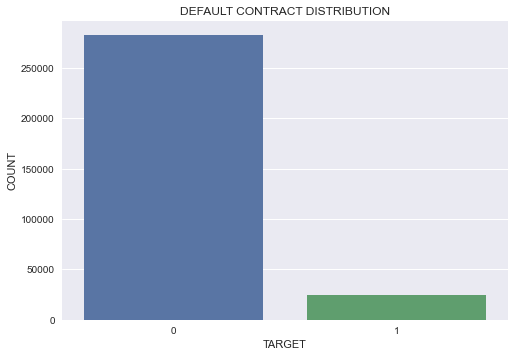

In [41]:
sns.countplot(x='TARGET', data=train_data)

plt.xlabel('TARGET')
plt.ylabel('COUNT')
plt.title('DEFAULT CONTRACT DISTRIBUTION')
plt.show()

### Client's Age Distribution

<AxesSubplot:xlabel='AGE', ylabel='Density'>

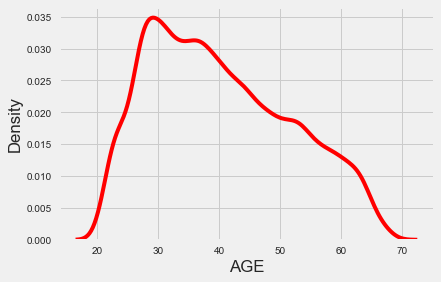

In [179]:
#For more intuitive sight, lets translate DAYS_BIRTH to AGE
train_data['AGE'] = train_data['DAYS_BIRTH'].apply(lambda x: math.floor(x/-365))

#Plotting distribution of Age who Defaulted
plt.style.use('fivethirtyeight')
sns.kdeplot(train_data[train_data['TARGET'] == 1]['AGE'],color='red')

### Contract Type Percentage

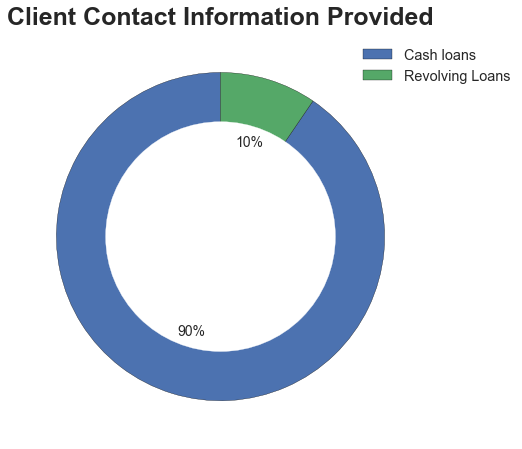

In [149]:
fig, ax = plt.subplots()

size = 0.3
vals = train_data['NAME_CONTRACT_TYPE'].value_counts()
my_circle = plt.Circle((0,0), 0.7, color='white')
cmap = plt.get_cmap("tab20c")
labels = ['Cash loans','Revolving Loans']

ax.pie(vals, radius=1, startangle=90, wedgeprops={'edgecolor': 'black'}, 
       textprops={'fontsize': 14}, autopct='%1.f%%')
plt.gcf().gca().add_artist(my_circle)

fig.set_figheight(8)
fig.set_figwidth(6)
fig.legend(labels=labels, fontsize='x-large',loc='upper right',bbox_to_anchor=(0.5, 0.35, 0.7, 0.5))
fig.tight_layout()
fig.suptitle('Client Contact Information Provided', fontsize=25, y=0.9, fontweight='bold', x=0.5)

fig.savefig('Opinions_ctq')
plt.show()

### Client's Contact Provided

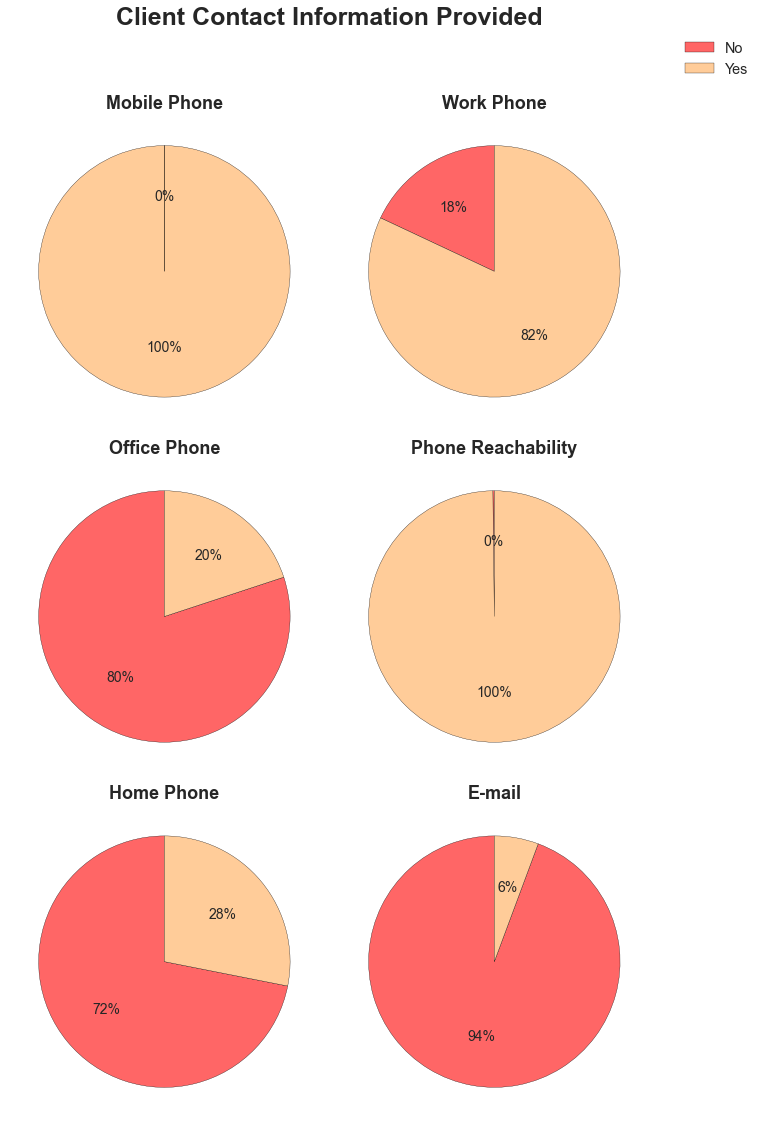

In [117]:
plt.style.use('seaborn')

#Building dataframe consist of customers data provided
cols_list = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
count_value = pd.DataFrame(columns=cols_list,index=[0,1])

for col in cols_list:
    count_value[col]= train_data[col].value_counts().to_frame()
count_value = count_value.T

fig, ax = plt.subplots(nrows=3, ncols=2)

labels = 'No', 'Yes'
colors = ['#ff6666', '#ffcc99']

plt.title('Client Contact Information')
plt.tight_layout()

#Plotting pie chart for every data kind
chart_title = ['Mobile Phone','Work Phone','Office Phone','Phone Reachability','Home Phone','E-mail']

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].pie(count_value.iloc[2*i+j], startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, 
                    textprops={'fontsize': 14}, autopct='%1.f%%')
        ax[i,j].set_title(chart_title[2*i+j], fontweight='bold',fontsize= 18)

fig.suptitle('Client Contact Information Provided', fontsize=25, y=1.04, fontweight='bold', x=0.5)
fig.set_figheight(15)
fig.set_figwidth(10)
fig.legend(labels=labels, fontsize='x-large',loc='upper right',bbox_to_anchor=(0.5, 0.52, 0.6, 0.5))
fig.tight_layout()

fig.savefig('Opinions_ctq')

plt.show()

## Client Registered Address

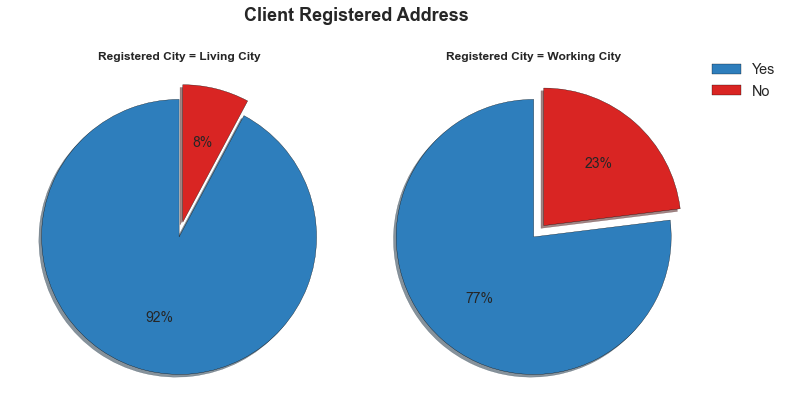

In [108]:
plt.style.use('seaborn')

#Building dataframe consist of customers data provided
cols_list = ['REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY']
count_value = pd.DataFrame(columns=cols_list,index=[0,1])

for col in cols_list:
    count_value[col]= train_data[col].value_counts().to_frame()
count_value = count_value.T

fig, ax = plt.subplots(nrows=1, ncols=2)
a,b = [plt.cm.Blues,plt.cm.Reds]
labels = 'Yes', 'No'

#Plotting pie chart for every data kind
chart_title = ['Registered City = Living City','Registered City = Working City']
my_circle = plt.Circle((0,0), 0.7, color='white')
explode = (0,0.11)

for i in range(0,2):
    ax[i].pie(count_value.iloc[i], explode = explode, startangle=90, shadow= True, 
              colors=[a(0.7),b(0.7)], wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%',textprops={'fontsize': 14})
    ax[i].set_title(chart_title[i], fontweight='bold')
    
fig.suptitle('Client Registered Address', fontsize=18, y=1, fontweight='bold', x=0.5)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.legend(labels=labels, fontsize='x-large',loc=1,bbox_to_anchor=(0.5, 0.4, 0.6, 0.5))
fig.tight_layout()

fig.savefig('Opinions_ctq')

plt.show()

### Client's Wealth

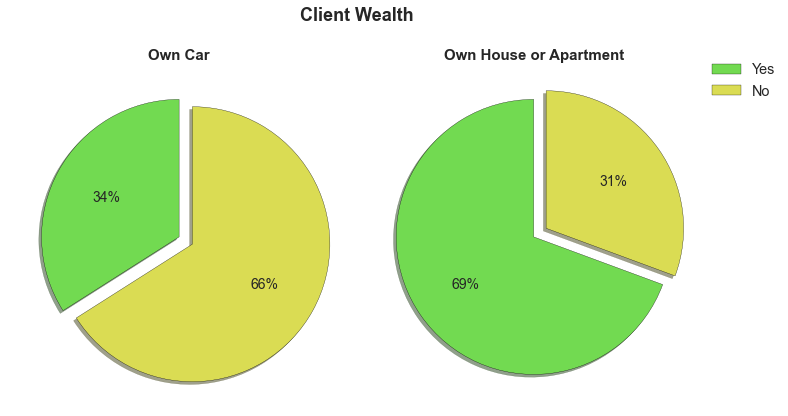

In [162]:
plt.style.use('seaborn')

#Building dataframe consist of customers data provided
cols_list = ['FLAG_OWN_CAR','FLAG_OWN_REALTY']
count_value = pd.DataFrame(columns=cols_list,index=['Y','N'])

for col in cols_list:
    count_value[col]= train_data[col].value_counts().to_frame()
count_value = count_value.T

fig, ax = plt.subplots(nrows=1, ncols=2)
colors = ['#72DA51','#DADC53']
labels = 'Yes', 'No'

#Plotting pie chart for every data kind
chart_title = ['Own Car','Own House or Apartment']
my_circle = plt.Circle((0,0), 0.7, color='white')
explode = (0,0.11)

for i in range(0,2):
    ax[i].pie(count_value.iloc[i], explode = explode, startangle=90, shadow= True, colors=colors,
              wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%',textprops={'fontsize': 14})
    ax[i].set_title(chart_title[i], fontweight='bold',fontsize=15)
    
fig.suptitle('Client Wealth', fontsize=18, y=1, fontweight='bold', x=0.5)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.legend(labels=labels, fontsize='x-large',loc=1,bbox_to_anchor=(0.5, 0.4, 0.6, 0.5))
fig.tight_layout()

fig.savefig('Opinions_ctq')

plt.show()

### Imputation

In [12]:
from impyute.imputation.cs import mice

# start the MICE training
imputed_training=mice(train_data.values)

BadInputError: Data is not float.

In [11]:
train_data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)